**ICX Media Data Science Code Challenge**

By: Yogesh Patil
<br>
MS Industrial Engineering 
<br>
University of Pittsburgh
<br>

The goal of this challenge is to use a data set that is not yet suited for supervised machine learning because it lacks the necessary target. We will use clustering to extrapolate and assign categories and then use those cluster labels for downstream classification.

**INTRODUCTION:**

The data contains real information about the student's knowledge status about the subject of Electrical DC Machines.It has been obtained from UCI ML Repo. It was the Ph.D. Thesis of Dr. Hamdi Tolga Kahraman back in 2009. It is an unlabelled dataset containing 5 features explained below:


STG (The degree of study time for goal object materials)
<br>
SCG (The degree of repetition number of user for goal object materials)
<br>
STR (The degree of study time of user for related objects with goal object)
<br>
LPR (The exam performance of user for related objects with goal object)
<br>
PEG (The exam performance of user for goal objects)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the data from the excel file 
orig = pd.read_excel(open('User Knowledge.xls', 'rb'), 'Main')
orig.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG'], dtype='object')

In [3]:
# Keep only the columns containing the data about student's knowledge
knowledge = orig.iloc[:,:5]
knowledge.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


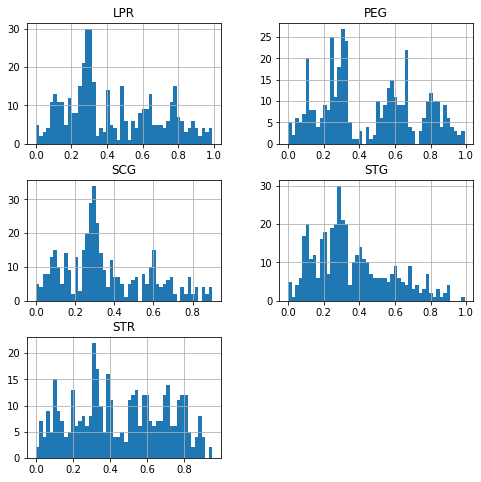

In [4]:
# Plot histograms of the featuers to visualize the data
knowledge.hist(bins=50, figsize = (8,8))
plt.show()

**THEORY**

The most common methods used for identifying clusters or classes in unlabelled data are: 1) K-Means Clustering and 2) Hierarchical Clustering. While both are used for the same purpose, their underlying techniques are different.

***K-Means Clustering***: We start by randomly selecting k points in the data as centroids of the k clusters. For each centroid, find the nearest points to that centroid, and assign them to its cluster. Calculate the average of all the points assigned to each cluster and those are the new centroids of the clusters.The iteration is repeated a few hundred times (or less, depending on the size of the dataset to reduce computing time) after which the final clusters are assigned to the data points. The results may vary significantly depending on the position of the initial clusters and hence we repeat the process a few times by randomly assigning different centroids every time and chosing the clusters that move the least upon iterating.

***Hierarchical Clustering***: This algorithm can use either of 2 approaches: Agglomerative or Divisive. In Agglomerative Hierarchical Clustering, each data point is a cluster to start with. A combined clusters is formed by combining clusters hacing minumum 'distance' in between them. This process is repeated till we get one cluster of all points. Then, we can use the dendogram to figure out the required number of clusters. Following are ways to calculate the 'distance' between two clusters:
<br>
Measure the distance between the closes points of two clusters.
<br>
Measure the distance between the farthest points of two clusters.
<br>
Measure the distance between the centroids of two clusters.
<br>
Measure the mean of the distance between all possible combination of points in the two clusters.

***Comparison***: It is natural to wonder which medhod to choose when performing a clustering task. There are several points of cmparison between the two: While Hierarchical Clustering is highly interpretable by looking at the dendograms, it has a higher time complexiy O(n^2) as compated to K-Means Clustering which has a linear time complexity O(n). Even by iterating K-Means for different initial clusters, it would be more efficient for clustering large amounts of data. In contrast, K-Means clustering requires the data to be continuous while Hierarchical Clustering can be run on categorical data by defining a similarity metric  rather than distance.

Note: If one of the features has a range of values much larger than the others, clustering will be completely dominated by that one feature. Hence, it is important to ensure that the range of the variables is similar by normalizing the data before clustering.

***Number of clusters***: Sometimes we might know exactly what is the number of clusters required for further analysis. For example, while clustering the data for physical features of people for clustering them into small, medium and large sized, we know that k is 3. However in some cases we might not be pre-decided about the number of clusters. In those cases, if using K-Means Clustering, we may use the 'elbow method' to choose the optimal number of clusters or use our judgement to choose where to draw the line in the dendograms obtained from Hierarchical Clustering.

In this analysis, we will explore K-Means clustering and look closely at the elbow method.

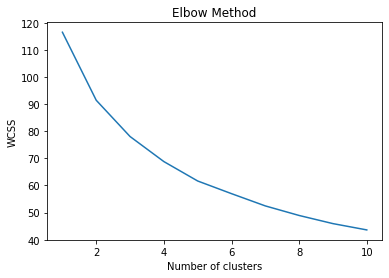

In [5]:
# Perform k-Means Clustering with values of k from 1 to 10 and plot k v/s Within Cluster Sum of Squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=400, n_init=20, random_state=0)
    kmeans.fit(knowledge)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In the elbow method, the optimal number of clusters is chosen as the point beyond which the rate of decrease of the within clusters sum of squares starts to fall significantly. In some cases, we need not use the elbow method if we are certain about the number of clusters required. For example, in this case, suppose that we wanted to form 3 clusters of student's knowledge to be able to classify them in three different groups and potentially use different strategies to help them better their knowledge.

In [6]:
# K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=400, n_init=20, random_state=0)
kmeans.fit(knowledge)
k_class = kmeans.predict(knowledge)

In order to visualize the data, we will perform Principal Component Analysis (Dimentionality Reduction). PCA basically rotates an axis in such a way that the resulting distribution of data data has maximum variance along this axis. The other axes will be also rotated in a manner perpendicular to the rest of the axes. Naturally, if we choose the top 2 or 3 axes along which the variance is maximum, it's possible to visualize the data in lower dimensions.

In [7]:
# Using PCA and filtering 3 principal components for data visualization
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(knowledge)
PDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

In [8]:
# Add a column 'Class' to the data sets
PDF.loc[:, 'Cluster'] = pd.Series(k_class)
knowledge_class = knowledge.copy()
knowledge_class['Class'] = k_class

In [9]:
# Count of points in each cluster
PDF['Cluster'].value_counts()

2    146
0    131
1    126
Name: Cluster, dtype: int64

In [10]:
# Assign a color to each cluster
PDF['Color'] = PDF['Cluster'].map({0 : 'red', 1 : 'blue', 2 : 'green'})

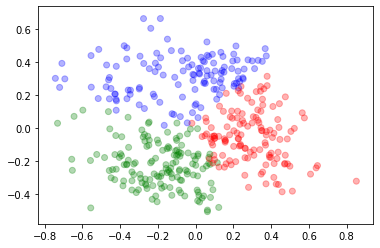

In [11]:
# Plot the first 2 principal components and color by cluster
a1 = PDF['PC1']
a2 = PDF['PC2']
a3 = PDF['PC3']
c1 = PDF['Color']
plt.scatter(a1, a2, c = c1, alpha=0.3, cmap='viridis')

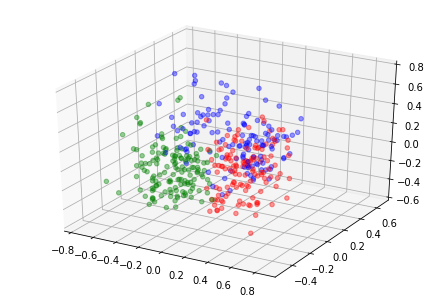

In [12]:
# 3-D plot of the data using 3 principal components
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(a1, a2, a3, alpha = 0.4, c = c1)

Let us look at how to the 3 classes differ by calculating their averages on each column.

In [13]:
knowledge_class.groupby(['Class']).mean()

,STG,SCG,STR,LPR,PEG
Class,,,,,
0,0.311137,0.267550,0.340992,0.299168,0.230634
1,0.381405,0.399984,0.513413,0.748095,0.410556
2,0.366438,0.397240,0.514212,0.276575,0.698425


Next, we want to perform classification on the data and the new categorical target values of class. We can use multiclass classification methods in Machine Learning on this data. The data appears to be well separated in space as seen from the plots. First we will split the data into training and test sets. Then, we will train the Machine Learning models on the trainnig data and evaluate their performance on the test data. There are numerous ways to evaluate performance of the model. Here, we will use the most simple metric, accuracy to evaluate our models. 

The algorithms to be used for this multi-class classification task and the reason why they were selected from the list of all algorithms are stated below:
* KNN (K-Nearest Neighbors) - KNN uses distance as the metric and the labels for the dataset were also obtained using distance as the metric when we applied K-Means Clustering. Thus, KNN may perform well on this dataset.


* Decision Tree Classifier - We almost always want to apply a few Machine Learning methods to any dataset and compare them based on a suitable evaluation metric rather than selecting one final model based only on intusion. Although decision tess may not perform best on a small data such as this one, they are highly interpretable.


* Naive Bayes - Based on assumption that variables are independent and making a probabilistic estimation using  amaximum likelihood hypothesis, this algorithm is highly efficient as compared to other Machine Lerning models.

In [14]:
# Slipt the data into train and test data sets
X = knowledge_class.iloc[:, :-1]
Y = knowledge_class.iloc[:, -1]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.25, random_state = 0)

Text(0.5, 1.0, 'k v/s Accuracy for KNN')

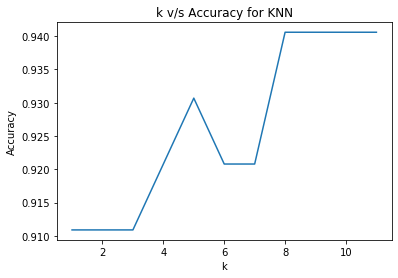

In [15]:
# KNN for various values of k and plot of k v/s accuracy
from sklearn.neighbors import KNeighborsClassifier
accuracy = []

for i in range(1,12):
    knn = KNeighborsClassifier(n_neighbors = i).fit(xTrain, yTrain)
    accuracy.append(knn.score(xTest, yTest))

plt.plot(range(1,12), accuracy)
plt.xlabel('k')
plt.ylabel('Accuracy') 
plt.title('k v/s Accuracy for KNN')

In [16]:
# KNN model and evaluation for optimal value of k (8 in this case)
knn = KNeighborsClassifier(n_neighbors = accuracy.index(max(accuracy))+1).fit(xTrain, yTrain)
knn_predictions = knn.predict(xTest)
knn_accuracy = knn.score(xTest, yTest)
knn_accuracy

0.9405940594059405

In [17]:
knn_CM = confusion_matrix(yTest, knn_predictions) # KNN Confusion Matrix
knn_CM

array([[29,  2,  1],
       [ 1, 29,  0],
       [ 1,  1, 37]], dtype=int64)

In [18]:
# Decision Tree Classifier and evaluation for optimal value of k
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(xTrain, yTrain) 
dtree_predictions = dtree_model.predict(xTest)
dt_accuracy = dtree_model.score(xTest, yTest)
dt_accuracy

0.9405940594059405

In [19]:
DT_CM = confusion_matrix(yTest, dtree_predictions) # Decision Tree confusion Matrix
DT_CM

array([[29,  2,  1],
       [ 0, 29,  1],
       [ 1,  1, 37]], dtype=int64)

In [20]:
# Gaussian Naive Bayes model and evaluation for optimal value of k
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(xTrain, yTrain)
gnb_predictions = gnb.predict(xTest)
gnb_accuracy = gnb.score(xTest, yTest)
gnb_accuracy

0.9603960396039604

In [21]:
NB_CM = confusion_matrix(yTest, gnb_predictions) # Naive Bayes confusion Matrix
NB_CM

array([[31,  0,  1],
       [ 0, 29,  1],
       [ 1,  1, 37]], dtype=int64)

We conclude  that the Naive Bayes classifier performed better than KNN and Decision Tree classifier because the model has highest score on test data and can be also seen by comparing the confusion matrices.